Based on:
https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches

In [3]:
# Read in csv of normalized traning data
train = pd.read_csv('../data/normalized_training_df.csv')
train.head()

,image_id,worm_type,xmin,ymin,xmax,ymax,number_of_worms,image_height,image_width,worm_code,xmin_norm,xmax_norm,ymin_norm,ymax_norm,xcenter_norm,ycenter_norm,width_norm,height_norm
0,id_8ada71185e18dc8838b4925b.jpg,pbw,2377.970000,156.770000,2478.890000,297.860000,2,3072,3072,1,0.774079,0.806930,0.051032,0.096960,0.790505,0.073996,0.032852,0.045928
1,id_8ada71185e18dc8838b4925b.jpg,pbw,715.390000,1221.460000,939.820000,1319.680000,2,3072,3072,1,0.232874,0.305931,0.397611,0.429583,0.269403,0.413597,0.073057,0.031973
2,id_8ada71185e18dc8838b4925b.jpg,abw,1129.730000,1558.060000,1559.700000,1966.300000,1,3072,3072,0,0.367751,0.507715,0.507181,0.640072,0.437733,0.573626,0.139964,0.132891
3,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,1743.676282,1537.210067,2090.216400,1799.814857,2,4000,3000,0,0.581225,0.696739,0.384303,0.449954,0.638982,0.417128,0.115513,0.065651
4,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,2162.137567,1676.304250,2342.256859,1952.269926,2,4000,3000,0,0.720713,0.780752,0.419076,0.488067,0.750732,0.453572,0.060040,0.068991


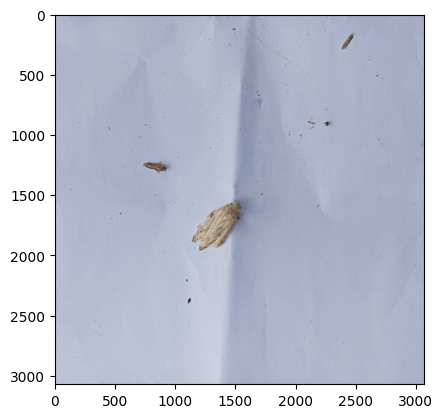

In [4]:
# See one of the images
image = plt.imread('../data/images/id_8ada71185e18dc8838b4925b.jpg')
plt.imshow(image)

In [6]:
# See how many unique training images there are
train['image_id'].nunique()

9737

In [19]:
train[train['number_of_worms']==0]

,image_id,worm_type,xmin,ymin,xmax,ymax,number_of_worms,image_height,image_width,worm_code,xmin_norm,xmax_norm,ymin_norm,ymax_norm,xcenter_norm,ycenter_norm,width_norm,height_norm
532,id_e45d64c9ab7a54e05b99ecdc.jpg,NaN,NaN,NaN,NaN,NaN,0,780,1040,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,id_55c69d3402c27bbe37ac6683.jpg,NaN,NaN,NaN,NaN,NaN,0,3000,4000,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
620,id_1b746acec11fc62f95db2bcb.jpg,NaN,NaN,NaN,NaN,NaN,0,1076,1910,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
641,id_5d6a2c8811a294f14bcde464.jpg,NaN,NaN,NaN,NaN,NaN,0,4000,2250,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
651,id_4e75189682009c5574f66c90.jpg,NaN,NaN,NaN,NaN,NaN,0,3000,3000,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9872,id_d19b17f61b6ddacfb3ae924c.jpg,NaN,NaN,NaN,NaN,NaN,0,3840,2160,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9957,id_d6e8627c4cd8825494315661.jpg,NaN,NaN,NaN,NaN,NaN,0,4160,3120,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10250,id_f5af7467096b0ab845d7dc08.jpg,NaN,NaN,NaN,NaN,NaN,0,8000,6000,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10289,id_8c63e8a65494a10e6f08c48f.jpg,NaN,NaN,NaN,NaN,NaN,0,4160,3120,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# See how many of each type of bollworm there are
train['worm_type'].value_counts()

pbw    127752
abw      9223
Name: worm_type, dtype: int64

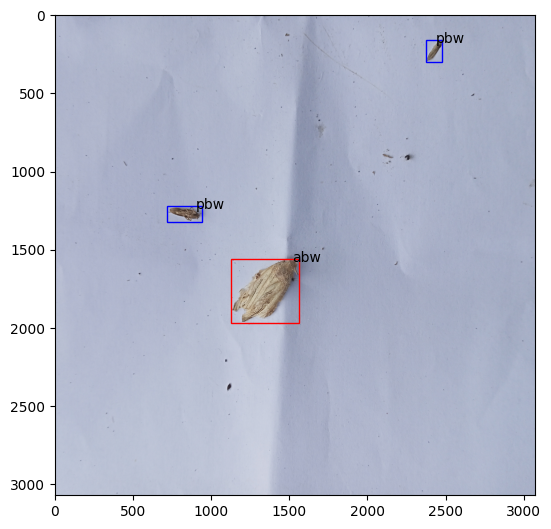

In [9]:
# See how image with detection boxes will look

# Set up figure
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

# Read in and plot image
image = plt.imread('../data/images/id_8ada71185e18dc8838b4925b.jpg')
plt.imshow(image)

# Loop over all rows with boxes for the image and make annotated box
for _,row in train[train.image_id == "id_8ada71185e18dc8838b4925b.jpg"].iterrows():
    
    # Get box boundaries
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    # Derive box width and height
    width = xmax - xmin
    height = ymax - ymin
    
    # Make box colors and annotations different for each worm type
    if row.worm_type == 'abw':
        edgecolor = 'r'
        ax.annotate('abw', xy=(xmax-40,ymin+20))
    elif row.worm_type == 'pbw':
        edgecolor = 'b'
        ax.annotate('pbw', xy=(xmax-40,ymin+20))
        
    # Add bounding boxes to image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    ax.add_patch(rect)

In [20]:
train[train['ymin']==0]

,image_id,worm_type,xmin,ymin,xmax,ymax,number_of_worms,image_height,image_width,worm_code,xmin_norm,xmax_norm,ymin_norm,ymax_norm,xcenter_norm,ycenter_norm,width_norm,height_norm
640,id_d1fb020be11637522a41627c.jpg,abw,25.974505,0.0,680.391163,630.238255,1,720,646,0,0.040208,1.053237,0.0,0.875331,0.546723,0.437665,1.013029,0.875331
7041,id_135dd65ea5ffc7c2c67fe7a2.jpg,abw,2512.000000,0.0,3305.000000,734.000000,7,4160,3120,0,0.805128,1.059295,0.0,0.176442,0.932212,0.088221,0.254167,0.176442
7822,id_1cc04a85af56ff126c94225e.jpg,abw,2378.000000,0.0,2858.000000,605.000000,8,4160,3120,0,0.762179,0.916026,0.0,0.145433,0.839103,0.072716,0.153846,0.145433
9571,id_314f7f381ec718f6c0ff04e1.jpg,abw,1331.000000,0.0,1778.000000,676.000000,7,4160,3120,0,0.426603,0.569872,0.0,0.162500,0.498237,0.081250,0.143269,0.162500
10160,id_870446f9fa07fbc52eaa0764.jpg,abw,1593.000000,0.0,2536.000000,753.000000,4,4160,3120,0,0.510577,0.812821,0.0,0.181010,0.661699,0.090505,0.302244,0.181010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130285,id_43e6dec0233f008e833ea41b.jpg,pbw,1455.400000,0.0,1625.350000,93.490000,115,4000,3000,1,0.485133,0.541783,0.0,0.023372,0.513458,0.011686,0.056650,0.023372
130326,id_43e6dec0233f008e833ea41b.jpg,pbw,3027.970000,0.0,3110.700000,62.900000,115,4000,3000,1,1.009323,1.036900,0.0,0.015725,1.023112,0.007862,0.027577,0.015725
130366,id_43e6dec0233f008e833ea41b.jpg,pbw,3116.050000,0.0,3205.850000,211.820000,115,4000,3000,1,1.038683,1.068617,0.0,0.052955,1.053650,0.026477,0.029933,0.052955
132313,id_012944c998fd7b1f24f28c43.jpg,pbw,443.818285,0.0,474.277496,15.586037,148,960,540,1,0.821886,0.878292,0.0,0.016235,0.850089,0.008118,0.056406,0.016235


In [22]:
train['ymin'].isnull().sum()

0

In [21]:
train['ymin'] = train['ymin'].fillna(0)
train['xmin'] = train['xmin'].fillna(0)
train['ymax'] = train['ymax'].fillna(0)
train['xmax'] = train['xmax'].fillna(0)

In [23]:
# Create new dataframe to get in required format
data = pd.DataFrame()

# Add image id column
data['format'] = train['image_id']

# Add pathway to image names
for i in range(data.shape[0]):
    data['format'][i] = '../../data/images/' + data['format'][i]

# Add xmin, ymin, xmax, ymax, and class as comma-delimited list to satisfy format requirements
for i in range(data.shape[0]):
    try:
        data['format'][i] = data['format'][i] + ',' + \
                            str(round(train['xmin'][i])) + ',' + \
                            str(round(train['ymin'][i])) + ',' + \
                            str(round(train['xmax'][i])) + ',' + \
                            str(round(train['ymax'][i])) + ',' + \
                            str(train['worm_type'][i])
    except:
        data['format'][i] = data['format'][i] + ',' + \
                            str(train['xmin'][i]) + ',' + \
                            str(train['ymin'][i]) + ',' + \
                            str(train['xmax'][i]) + ',' + \
                            str(train['ymax'][i]) + ',' + \
                            str(train['worm_type'][i])

# Save formatted data to textfile
data.to_csv('annotate.txt', header=None, index=None, sep=' ')

### Train Model

In [ ]:
! cd keras-frcnn
! python train_frcnn.py -o simple -p ../annotate.txt --num_epochs 50